# Isolation Forest + Classic Autoencoder

## 1. Import basic libraries

In [0]:
%%capture
#Install skorch package 
!pip install skorch

In [0]:
#Data managment 
import pandas as pd 
import numpy as np 

#Vizualization 
from matplotlib import pyplot as plt

#Torch
import torch
from torch import nn, optim
import torch.nn.functional as F

#Sklearn tools
from sklearn.model_selection import train_test_split

#Torch wrapper
import skorch
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, LRScheduler

#Utilities
import os

## 2. Download Preprocessed Data

In [0]:
%%capture
#Get data
if not os.path.isfile('all_scaled0_1.csv'): 
    !wget 'https://drive.google.com/uc?export=download&id=1-ET9vXPKudU92XuWeR0wIL67byS2llq-' -O all_scaled0_1.csv
if not os.path.isfile('data_final_feat_scaled0_1.csv'): 
    !wget 'https://drive.google.com/uc?export=download&id=14Qasv71GRD3kT3GhyI2v6c8v4L6YIBy0' -O data_final_feat_scaled0_1.csv

## 3. Parse Data and Split Data

In [0]:
#data_file = 'all_scaled0_1.csv'
data_file = 'data_final_feat_scaled0_1.csv'

In [113]:
data = pd.read_csv(data_file,index_col=0)
labels = data['label']
run = data['run']
chunkID = data['chunkID']
period = data['period']
data = data.drop(['label','chunkID','run','period'], axis = 1)
no_samples, no_features = data.shape
print('Samples, Features: ', no_samples, no_features)
print(labels.value_counts())
data.head()

Samples, Features:  3429 128
0.0    3262
1.0     167
Name: label, dtype: int64


,dcar_posA_2_Err,slopedZAchi2Pos,MIPattachSlopeC,meanMultNeg,mediumPtAPos,dcarCP0,dcaz_negA_1_Err,tpcConstrainPhiA,dcar_negA_chi2,offsetdZC,dcaz_negA_0_Err,zPullHighPt,vertOK,tpcItsMatchHighPtA,deltaPt,resolutionMIP,entriesVertY,entriesMult,dcaz_posA_0,dcar_posC_1,slopedRAchi2Pos,tpcConstrainPhiC,iroc_A_side,meanVertZ,slopedZAchi2,deltaPtC,offsetdZAErr,offsetdZA,dcaz_posA_2_Err,dcaz_negC_0_Err,offsetdRA,meanMIPele,offsetdZAchi2Pos,medianHVandPTGainCorrIROC,iroc_C_side,vertAll,dcar_negA_1_Err,offsetdRAchi2Pos,meanMult,qOverPtC,...,phiPull,rmsTPCChi2,dcar_negC_1_Err,offsetdRCchi2,meanTPCChi2,rmsVertY,tpcItsMatchHighPtC,dcaz_negC_2_Err,yPullHighPt,tpcItsMatchC,deltaPtchi2C,deltaPtchi2,rmsMultNeg,meanTPCnclF,ptPullHighPt,oroc_C_side,slopedZCchi2Pos,rmsTPCncl,dcar_posC_2_Err,offsetdZCchi2Pos,deltaPtchi2A,resolutionMIPele,dcarCP1,dcar_posA_1_Err,slopedRCchi2Pos,slopeCTPCnclFErr,slopeCTPCnclF,dcar_negC_0_Err,slopedZC,lambdaPull,dcaz_posC_1_Err,offsetdRCchi2Neg,dcaz_negC_chi2,offsetdRCchi2Pos,dcaz_posC_0_Err,oroc_A_side,offsetdZAchi2,dcar_negA_0_Err,dcar_negC_chi2,slopeATPCnclF
0,0.084978,0.018955,0.842762,0.171907,0.269421,0.012700,0.073086,0.365811,0.040081,0.456515,0.075152,0.494765,0.072495,0.573832,0.778597,0.094750,0.072495,0.072495,0.402053,0.832478,0.017025,0.029029,1.0,0.314548,0.066360,0.607326,0.029047,0.676500,0.080796,0.064750,0.827629,0.539362,0.018955,0.643058,1.0,0.072211,0.082068,0.017025,0.170502,0.999787,...,0.279488,0.299807,0.089595,0.165264,0.586648,0.111019,0.582128,0.066403,0.397318,0.586826,0.232100,0.210562,0.220209,0.650378,0.478282,1.0,0.103951,0.130696,0.062340,0.103951,0.254022,0.377138,0.863747,0.091667,0.166519,0.506033,0.506033,0.092639,0.479150,0.564013,0.063305,0.169389,0.049049,0.166519,0.060923,1.0,0.066360,0.089056,0.096599,0.567304
1,0.083858,0.078152,0.828729,0.173973,0.240232,0.013681,0.072295,0.279536,0.029575,0.656468,0.074312,0.458420,0.074775,0.549569,0.745472,0.091434,0.074775,0.074775,0.388408,0.802137,0.005406,0.084570,1.0,0.298703,0.098105,0.597697,0.028192,0.672718,0.079918,0.062965,0.794622,0.539610,0.078152,0.644604,1.0,0.074384,0.080961,0.005406,0.171713,0.999787,...,0.295763,0.299619,0.087815,0.277622,0.579001,0.115167,0.581842,0.064488,0.428699,0.583827,0.149810,0.385217,0.236852,0.652363,0.508984,1.0,0.195836,0.129801,0.061326,0.195836,0.515967,0.377678,0.864576,0.090594,0.270753,0.490807,0.490807,0.090666,0.622429,0.559882,0.061817,0.295496,0.053690,0.270753,0.059619,1.0,0.098105,0.088029,0.080482,0.553643
2,0.083916,0.144460,0.829774,0.176758,0.276467,0.013235,0.071540,0.319029,0.040652,0.774050,0.073681,0.461882,0.075070,0.567858,0.739555,0.089755,0.075070,0.075069,0.394434,0.787007,0.014864,0.133775,1.0,0.281690,0.102944,0.589850,0.027634,0.709053,0.079374,0.062983,0.800667,0.539159,0.144460,0.644119,1.0,0.074775,0.080976,0.014864,0.175191,0.999787,...,0.281763,0.302841,0.087507,0.349164,0.582115,0.119110,0.586257,0.064412,0.420849,0.584458,0.421557,0.435664,0.234255,0.656779,0.493338,1.0,0.224404,0.128520,0.061049,0.224404,0.247578,0.377654,0.864001,0.090476,0.332814,0.486826,0.486826,0.090231,0.716557,0.561373,0.061571,0.391960,0.070414,0.332814,0.059297,1.0,0.102944,0.088169,0.067023,0.576802
3,0.085152,0.084640,0.835028,0.174482,0.258437,0.016565,0.072717,0.251844,0.024053,0.865839,0.074933,0.496001,0.073988,0.541670,0.761264,0.091761,0.073988,0.073987,0.389906,0.784608,0.016920,0.160170,1.0,0.291844,0.074307,0.600640,0.029305,0.684981,0.080639,0.064623,0.779825,0.539396,0.084640,0.637938,1.0,0.073704,0.081358,0.016920,0.172629,0.999787,...,0.270435,0.307098,0.088426,0.427887,0.590880,0.113392,0.589802,0.066359,0.439337,0.572863,0.565959,0.406805,0.229296,0.650338,0.537189,1.0,0.224069,0.127972,0.062087,0.224069,0.425016,0.377537,0.863877,0.091592,0.391857,0.465535,0.465535,0.091349,0.786867,0.529956,0.063318,0.491013,0.095369,0.391857,0.060874,1.0,0.074307,0.088482,0.065335,0.573718
4,0.083390,0.070673,0.833388,0.174964,0.265868,0.016429,0.071677,0.286252,0.048721,0.7102

In [114]:
#Split train/test
size_of_test = 0.2 

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=size_of_test,stratify=labels)
print('Values in test set:')
print(y_test.value_counts())
print('Train shape test:')
print(X_train.shape)

Values in test set:
0.0    653
1.0     33
Name: label, dtype: int64
Train shape test:
(2743, 128)


## 4. Filter Outliers From Training Set Using Isolation Forest

In [115]:
from sklearn.ensemble import IsolationForest

forest = IsolationForest(n_estimators = 100, contamination='auto')
pred = forest.fit_predict(X_train)
#Check where prediction of isolation forrest was matching 
corr_macthes = np.where(((pred == -1) & (y_train == 1)),1,0).sum()
print('Found {} outliers in {} samples.'.format(pd.Series(pred).value_counts()[-1], X_train.shape[0]))
print('Out of those {} have warning flag.'.format(corr_macthes))

#Filter Outliers From trainign sets
X_train = X_train[pred==1]
y_train = y_train[pred==1]

print(X_train.shape)

Found 136 outliers in 2743 samples.
Out of those 105 have warning flag.
(2607, 128)


## 5. Define Model Architecture

In [0]:
class Encoder(nn.Module):
    def __init__(self, no_features, lat_r, dropout):
        super().__init__()
        NF = no_features
        self.fc1 = nn.Linear(NF, round(lat_r[0]*NF))
        self.fc2 = nn.Linear(round(lat_r[0]*NF), round(lat_r[1]*NF))
        self.fc3 = nn.Linear(round(lat_r[1]*NF), round(lat_r[2]*NF))
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(self.fc3(x)) #Only droput on last layer no ReLu
        return x

class Decoder(nn.Module):
    def __init__(self, no_features, lat_r, dropout):
        super().__init__()
        NF = no_features
        self.fc1 = nn.Linear(round(lat_r[2]*NF), round(lat_r[1]*NF))
        self.fc2 = nn.Linear(round(lat_r[1]*NF), round(lat_r[0]*NF))
        self.fc3 = nn.Linear(round(lat_r[0]*NF), NF)
        self.dropout = nn.Dropout(p=dropout)       
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))
        return x

In [0]:
class SimpleAutoEncoder(nn.Module):
    def __init__(self, no_features, lat_r, dropout):
        super().__init__()

        self.encoder = Encoder(no_features, lat_r, dropout)
        self.decoder = Decoder(no_features, lat_r, dropout)
        
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

In [118]:
# check if CUDA is available
gpu = torch.cuda.is_available()
if not gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## 7. Create Model Wrapper

In [0]:
#Parameters setting
max_epochs = 100
dropout = 0.2
batch_size = 32
start_lr = 0.007 #Starting learning rate 

#Learning Rate scheduler
patience = 5 #After how many epochs with no improvemnt change LR
factor = 0.8 #Scale factor of LR 

#Encoding
latent_ratio = [0.5, 0.3, 0.2] #Must be 3 elements

In [120]:
#Create callbacks
model_path = 'skorch_ae_model.pt'
checkpoint = Checkpoint(f_params=model_path, monitor='valid_loss_best')
scheduler = LRScheduler(policy='ReduceLROnPlateau', monitor='valid_loss', factor = factor, patience = patience, threshold=1e-3) 

net = NeuralNetRegressor(
    SimpleAutoEncoder,
    module__no_features = no_features,
    module__lat_r = latent_ratio,
    module__dropout = dropout,
    batch_size = batch_size,
    lr=start_lr,
    optimizer = optim.Adam,
    max_epochs=max_epochs,
    train_split=skorch.dataset.CVSplit(3),
    device='cuda' if gpu else 'cpu',
    callbacks=[checkpoint, scheduler],
    verbose = 1
)
#Default criterion is <class 'torch.nn.modules.loss.MSELoss'>
print(net)

<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.SimpleAutoEncoder'>,
  module__dropout=0.2,
  module__lat_r=[0.5, 0.3, 0.2],
  module__no_features=128,
)


## 8. Train Autoencoder

In [121]:
#Load model with lowest validation accuracy
net.initialize()  # This is important!

#Change training set to tensor and train network
X_train_t = torch.FloatTensor(X_train.to_numpy())
_ = net.fit(X_train_t,X_train_t) #output compared with imput, hide output

Re-initializing module because the following parameters were re-set: dropout, lat_r, no_features.
Re-initializing optimizer.
  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.0214        0.0069     +  0.2487
      2        0.0073        0.0069     +  0.2228
      3        0.0071        0.0069     +  0.2728
      4        0.0070        0.0068     +  0.2626
      5        0.0058        0.0044     +  0.2045
      6        0.0049        0.0041     +  0.2073
      7        0.0044        0.0036     +  0.2646
      8        0.0041        0.0034     +  0.2637
      9        0.0040        0.0034     +  0.2495
     10        0.0041        0.0034     +  0.2052
     11        0.0039        0.0032     +  0.2534
     12        0.0038        0.0031     +  0.2609
     13        0.0037        0.0027     +  0.2028
     14        0.0034        0.0027     +  0.2023
     15        0.0034        0.0027     +  0.2382
     16        0.0033    

## 9. Define Evaluation Functions

In [0]:
#Define function calculating losses of test samples
def aeTestLosses(X_test, X_pred):
    '''
    X_test, X_pred need to be tensors!
    Return list of all scores.
    '''
    scores = []
    loss_func = nn.MSELoss()
    for t,p in zip(X_test, X_pred):
        mse_loss = loss_func(t,p).item()
        scores.append(mse_loss)

    return np.array(scores)

#Define function for MSE vizualisation 
def mseVizualisation(outliers, inliers):
    max_val = np.concatenate((outliers, inliers)).max()
    fig, ax = plt.subplots(figsize = (20, 3))

    plt.hlines(0,0,max_val)  # Draw a horizontal line
    plt.ylim(-0.5,0.5)  

    plt.plot(inliers, np.zeros(inliers.shape) ,'.', ms = 10, color='blue') 
    plt.plot(outliers, np.zeros(outliers.shape) ,'x', ms = 10, color='red') 

    plt.title('Mean Square Error of Sample Reconstrution.')
    plt.xlabel('MSE')
    plt.legend(['Inliners','Outliers'])
    plt.yticks([])
    plt.show()

from sklearn.metrics import roc_curve, precision_recall_curve, auc

#Define functions for calculation and visualization of ROC and Prec and Recall 
def rocVizualisation(y_test, pred_scores):
    fpr, tpr, thresholds = roc_curve(y_test, all_scores, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize = (8,6))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.title('ROC curve')
    plt.plot(fpr, tpr, color='b', lw=2, label='AUC = %0.2f)' % roc_auc)
    plt.legend(loc="lower right")
    plt.show()

def prec_recallVizualisation(y_test, pred_scores):
    precision, recall, thresholds = precision_recall_curve(y_test, all_scores, pos_label=1)
    prec_recall_auc = auc(recall, precision)

    plt.figure(figsize = (8,6))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.plot([0, 1],[0.5, 0.5], color='red', linestyle='--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.title('Precision-Recall curve')
    plt.plot(recall, precision, color='b', lw=2, label='AUC area = %0.2f)' % prec_recall_auc)
    plt.legend(loc="lower right")
    plt.show()

def getCutOff(y_test, pred_scores):
    '''
    Return threshold with best sum of precision and recall 
    '''
    precision, recall, thresholds = precision_recall_curve(y_test, all_scores, pos_label=1)
    return thresholds[np.argmax(precision + recall)]

## 10. Evaluation

In [123]:
#Load model with lowest validation accuracy
net.initialize()  # This is important!
net.load_params(model_path)

#Create test tensors 
X_test_t = torch.FloatTensor(X_test.to_numpy())

#Run prediction and change to tensor
reconstruction = net.predict(X_test_t)
reconstruction_t = torch.FloatTensor(reconstruction)

#Get MSE of correct inliner and outliers
all_scores = aeTestLosses(X_test_t, reconstruction_t)
outliers = all_scores[y_test == 1]
inliers = all_scores[y_test == 0]

Re-initializing module because the following parameters were re-set: dropout, lat_r, no_features.
Re-initializing optimizer.


Score of AE: 47.06mu


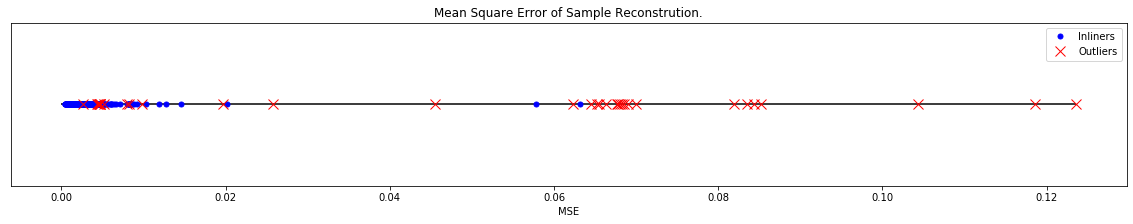

In [124]:
#Count score of autoencoder and vizualize
as_score = sum(outliers)/len(outliers) - sum(inliers)/len(inliers)
print('Score of AE: {:0.2f}mu'.format(as_score*1000))

mseVizualisation(outliers, inliers)

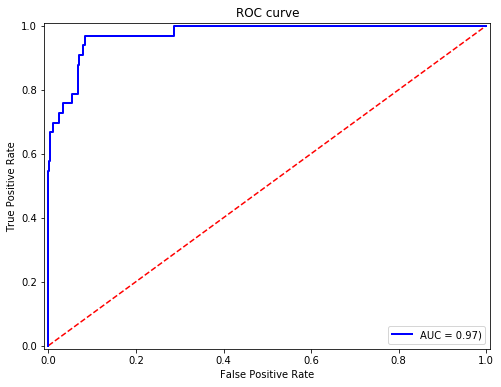

In [125]:
#Show ROC curve
rocVizualisation(y_test.to_numpy(), all_scores)

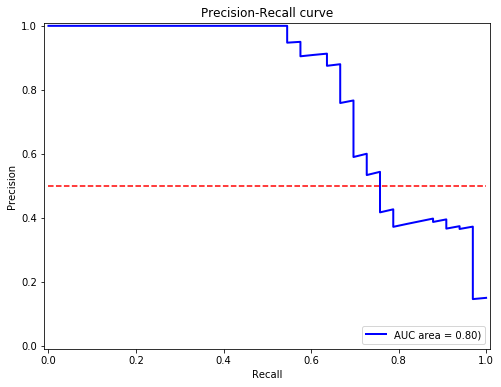

In [126]:
#Show Precision Recall curve
prec_recallVizualisation(y_test.to_numpy(), all_scores)

In [127]:
#Get optimal cut off point and check accuracy and balanced accuracy 
from sklearn.metrics import accuracy_score, balanced_accuracy_score

#Cut of point is point with highest sum of precision + recall
cut_off = getCutOff(y_test.to_numpy(), all_scores)
#If higher than cutoff point then outlier
pred = np.where(all_scores>cut_off, 1 ,0)

acc = accuracy_score(pred, y_test.to_numpy())
b_acc = balanced_accuracy_score(pred, y_test.to_numpy())

print('Accuracy score: {:.2f}%'.format(acc*100))
print('Balanced accuracy score: {:.2f}%'.format(b_acc*100))

Accuracy score: 97.81%
Balanced accuracy score: 94.48%


## 11. Explenation of Outliers

In [128]:
#Pick first 3 outliers and show worse reconstructed parameters

outliers_rec = reconstruction[y_test == 1][:3]
print('Parameters with highest reconstruction error for outliers: \n')
for i in outliers_rec:
    args = i.argsort()[-10:][::-1] #Get biggest errors indices
    print(list(data.columns[args]))

Parameters with highest reconstruction error for outliers: 

['oroc_A_side', 'iroc_A_side', 'MIPattachSlopeA', 'iroc_C_side', 'oroc_C_side', 'hasRawQA', 'qOverPtC', 'dcarCP1', 'lambdaPullHighPt', 'offsetdRC']
['iroc_C_side', 'oroc_C_side', 'MIPattachSlopeA', 'qOverPtC', 'dcarCP1', 'deltaPtA', 'lambdaPullHighPt', 'offsetdRC', 'MIPattachSlopeC', 'highPtAPos']
['oroc_A_side', 'iroc_A_side', 'hasRawQA', 'qOverPtC', 'MIPattachSlopeA', 'iroc_C_side', 'oroc_C_side', 'dcarCP1', 'lambdaPullHighPt', 'MIPattachSlopeC']
